<a href="https://colab.research.google.com/github/Mastemace/GZAPV_2021/blob/main/P20041/GZAPV_cv_04_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!nvidia-smi

Wed Apr 21 13:18:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip install segmentation_models
!wget https://graphicwg.irafm.osu.cz/storage/carvana.zip --no-check-certificate
!wget https://graphicwg.irafm.osu.cz/storage/carvana.h5 --no-check-certificate
!unzip carvana.zip

--2021-04-21 13:18:22--  https://graphicwg.irafm.osu.cz/storage/carvana.zip
Resolving graphicwg.irafm.osu.cz (graphicwg.irafm.osu.cz)... 78.128.129.71, 2001:718:1005:950::71
Connecting to graphicwg.irafm.osu.cz (graphicwg.irafm.osu.cz)|78.128.129.71|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 161308847 (154M) [application/zip]
Saving to: ‘carvana.zip.2’

carvana.zip.2       100%[===================>] 153.84M  16.6MB/s    in 11s     

2021-04-21 13:18:34 (13.5 MB/s) - ‘carvana.zip.2’ saved [161308847/161308847]

--2021-04-21 13:18:34--  https://graphicwg.irafm.osu.cz/storage/carvana.h5
Resolving graphicwg.irafm.osu.cz (graphicwg.irafm.osu.cz)... 78.128.129.71, 2001:718:1005:950::71
Connecting to graphicwg.irafm.osu.cz (graphicwg.irafm.osu.cz)|78.128.129.71|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 215681968 (206M)
Saving to: 

In [6]:
%env SM_FRAMEWORK = tf.keras

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from glob import glob
import random

import segmentation_models as sm

!pip install -q -U albumentations
import albumentations as A

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 37.6MB 80kB/s 
     |████████████████████████████████| 952kB 53.6MB/s 


In [7]:
BATCH_SIZE = 8

In [8]:
#model = sm.Unet('resnet18', classes=2, input_shape=(320, 480, 3), encoder_weights=None)
model = sm.Unet('efficientnetb3', classes=2, input_shape=(320, 480, 3), encoder_weights=None)
model.load_weights('carvana.h5')
model.compile('Adam', sm.losses.DiceLoss())
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 480, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 160, 240, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 160, 240, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 160, 240, 40) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [9]:
def load_data(path_imgs, path_labs):
    imgs = []
    labs = []
    for file in sorted(glob(path_imgs+'/*.*')): 
        im  = cv.imread(file)
        lab = cv.imread(file.replace('.jpg', '_mask.png').replace(path_imgs, path_labs),0)
        
        imgs.append(cv.cvtColor(im, cv.COLOR_BGR2RGB))
        labs.append(lab)
    return np.asarray(imgs), np.asarray(labs)
    
x_train, y_train = load_data('train', 'train_masks')    
x_valid, y_valid = load_data('valid', 'valid_masks')    
                          
print('train:', x_train.shape, y_train.shape)
print('valid:', x_valid.shape, y_valid.shape)

train: (4888, 320, 480, 3) (4888, 320, 480)
valid: (200, 320, 480, 3) (200, 320, 480)


In [10]:
def augment(img, lab):
    t = A.Compose([A.OneOf([
                            A.RandomBrightness(limit=.2, always_apply=False, p=.5)], 
                           p=0.5)
    ]
    )

    aug = t(image=img, mask=lab)
    image = aug['image']
    image = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    h_change = random.randrange(0, 179)

    mask = aug['mask']
  

    return 

In [11]:
#vlastni generator dat s wrappery
def data_generator(is_train):
    while True:
        g_images = []
        g_labels = []
        for b in range(BATCH_SIZE):
            if is_train == True:
                index = random.randrange(0, len(x_train))
                g_im, g_la = x_train[index], y_train[index]
                g_im, g_la = augment(g_im, g_la)
            else:
                index = random.randrange(0, len(x_valid))
                g_im, g_la = x_valid[index], y_valid[index]
            mask = np.zeros((g_la.shape[0], g_la.shape[1], 2))
            mask[...,0] = g_la==0
            mask[...,1] = g_la==255
            g_images.append(g_im)
            g_labels.append(mask)
        g_images = np.asarray(g_images)
        g_labels = np.asarray(g_labels)

        yield g_images.astype('float32'), g_labels.astype('float32')

def data_generator_wrapper_train():
    return data_generator(True)

def data_generator_wrapper_valid():
    return data_generator(False)

In [12]:
a = data_generator(True)
x, y = next(a)
print(x.shape)
print(y.shape)

TypeError: ignored

In [13]:
plt.imshow(x[0,...].astype(int))
plt.show()
plt.imshow(y[0,...,0].astype(int))
plt.show()
plt.imshow(y[0,...,1].astype(int))

NameError: ignored

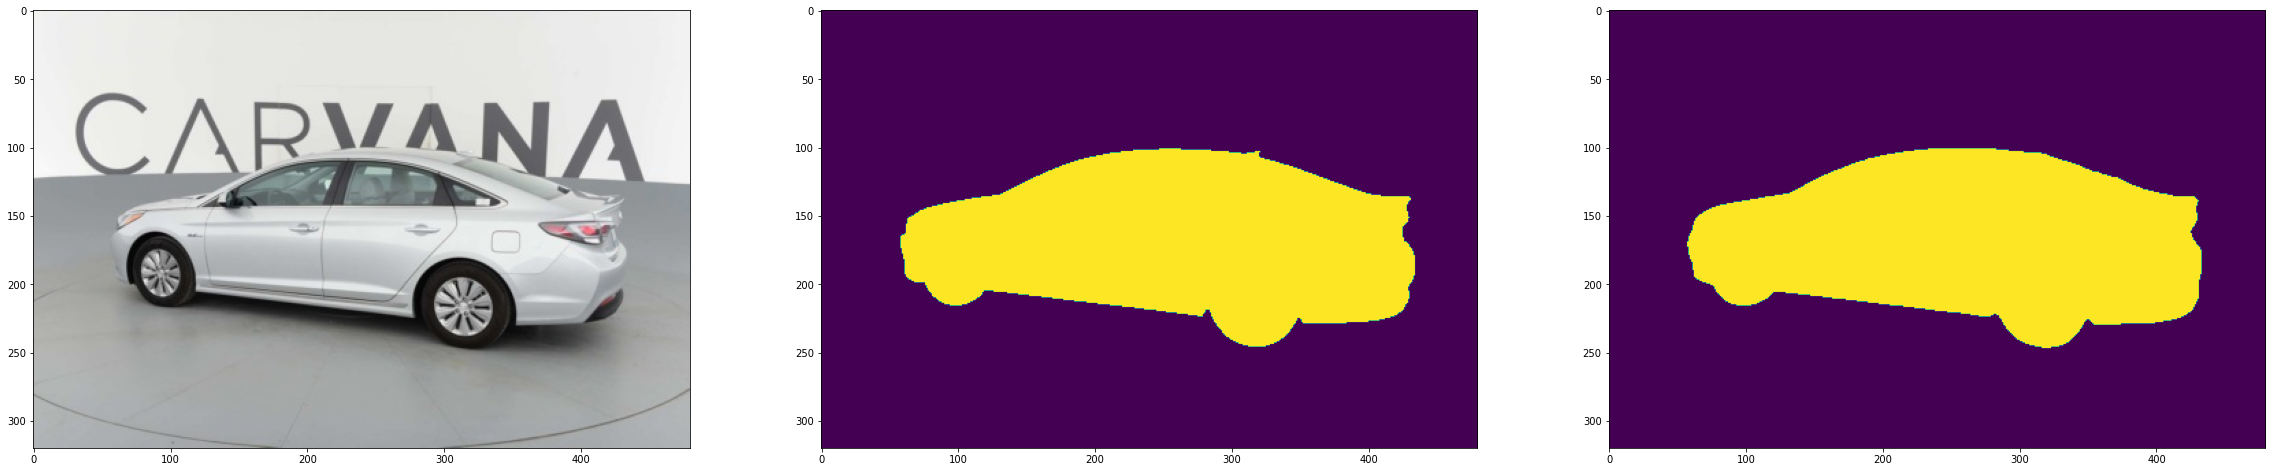

598


In [14]:
index = 21

out = model.predict(x_valid[index:index+1])
out = out[0]
out = np.argmax(out, axis=2)

g_la = y_valid[index]
mask = np.zeros((g_la.shape[0], g_la.shape[1], 2))
mask[...,0] = g_la==0
mask[...,1] = g_la==255
mask = np.argmax(mask, axis=2)

out = cv.medianBlur(out.astype('uint8'),5)

plt.figure(figsize=(40,10))
plt.subplot(1,3,1)
plt.imshow(x_valid[index])
plt.subplot(1,3,2)
plt.imshow(mask)
plt.subplot(1,3,3)
plt.imshow(out)
plt.show()

print(np.sum(np.abs(out-mask)))

In [ ]:
model.fit(data_generator_wrapper_train(),
          batch_size=BATCH_SIZE,
          validation_data=data_generator_wrapper_valid(),
          epochs=20,
          steps_per_epoch=len(x_train)//BATCH_SIZE,
          validation_steps=x_valid.shape[0]//BATCH_SIZE)

Epoch 1/20
611/611 [==============================] - 412s 612ms/step - loss: 0.0978 - val_loss: 0.0128
Epoch 2/20
611/611 [==============================] - 375s 613ms/step - loss: 0.0105 - val_loss: 0.0094
Epoch 3/20
611/611 [==============================] - 375s 613ms/step - loss: 0.0100 - val_loss: 0.0069
Epoch 4/20
611/611 [==============================] - 375s 614ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 5/20
482/611 [======================>.......] - ETA: 1:18 - loss: 0.0067

In [ ]:
print(x_valid.shape)
print(len(x_valid))